# Program to validate the iterative method

First install particle mesh

In [1]:
pip install pmesh

  Using cached pmesh-0.1.56-cp39-cp39-linux_x86_64.whl
  Using cached mpsort-0.1.17-cp39-cp39-linux_x86_64.whl
  Using cached pfft_python-0.1.21-cp39-cp39-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


Import packages

In [2]:
import numpy as np
from mpi4py import MPI
import pmesh.pm as pmesh
import matplotlib.pyplot as plt
from scipy import special # error func

comm = MPI.COMM_WORLD

Prerequirementes - define the analtical functions:
* $\psi (\mathbf{r})$: the electrostatic potential to be validated 
* $\epsilon(\mathbf{r})$: the dielectric, an anistropic permittivity function
* $\rho(\mathbf{r})$: The analytically determined charge density 

$\epsilon(\mathbf{r})$ and $\rho(\mathbf{r})$ is to be given as input to the iterative-GPE solver. The functions are given below.

In [3]:
## setting up the needed functions
def psi_analytic(x,y,z,mu_x,mu_y,mu_z):
    sigma = 0.5
    d = 3
    denom = ((sigma**d) * (np.sqrt(2 * np.pi)**d))
    A = 1.0/denom
    return A * np.exp(-(1/(2 * sigma**2)) * ((x - mu_x)**2 + (y - mu_y)**2 \
            + (z - mu_z)**2)) 

def dielectric(x,y,z):
    eps_0 = 78.36; delta = 0.3; d0 = 1.7
    r = np.sqrt(x**2 + y**2 + z**2) # + z**2) #+ z**2)
    h = 1.0/2 * (1 + special.erf((r - d0)/delta))
    return 1 + (eps_0 - 1) * h


def densities_analytic(x,y,z,mu_x,mu_y,mu_z, eps = dielectric, f = psi_analytic):
    d = 3
    eps_0 = 78.36; delta = 0.3; d0 = 1.7
    r = np.sqrt(x**2 + y**2 + z**2)
    sigma = 0.5
    ## gromacs units
    COULK_GMX = 138.935458 # the 1/(4pi eps0) Gromacs units  ## need to use pmesh units, then transfer back to plot
    eps_vacuum = 1.0/(COULK_GMX*4*np.pi)
    c = 1.0/np.sqrt(np.pi)*(eps_0 - 1)
    expr1 = eps(x,y,z)*(r**2/sigma**4 - 3.0/sigma**2)*f(x,y,z,mu_x,mu_y,mu_z)
    expr2 = r/(delta*sigma**2)*f(x,y,z,mu_x,mu_y,mu_z)*np.exp(-((r-d0)/delta)**2)
    return -1.0*(expr1 - c*expr2)*eps_vacuum


#### To rule out errors other than iterative
def dielectric_const(x,y,z,N):
    val = np.zeros((N,N,N)) + 80
    return val

def densities_eps_const(x,y,z,mu_x,mu_y,mu_z, eps = dielectric_const, f = psi_analytic):
    d = 3
    r = np.sqrt(x**2 + y**2 + z**2)
    sigma = 0.5
    COULK_GMX = 138.935458 # the 1/(4pi eps0) Gromacs units  ## need to use pmesh units, then transfer back
    eps_vacuum = 1.0/(COULK_GMX*4*np.pi)
    return -80.0*(r**2/sigma**4 - 3/sigma**2)* f(x,y,z,mu_x,mu_y,mu_z)*eps_vacuum


Define some global objects

In [4]:
mu_x = mu_y = mu_z = 0.0
dims = 3
COULK_GMX = 138.935458 # the 1/(4pi eps0) Gromacs units  

## Iterative method:

Define the iterative GPE-solver, which also initizalizes the pmeshes needed in the iteration process, in order to make different validation options more streamlined and accessible. 
* Inputs: It takes the number of mesh points which will give a cubic NxNxN grid, and it takes the smearing for the window function as input as well. The window function is needed in the Hamiltonian formalism of the hybrid particle-field. Const is an input defaulting to false, meaning that a variable dielectric is being solved for, instead of a constant dielectric of 80. 
* Outputs: The outputs are the electrostatic potential, the accuracy and the difference in polarization charges $\rho_{pol}$ throughout the iterations up to and with the iteration of convergence. It also outputs $i$ and $\rho_\text{pol}$for plotting reasons. 

In [46]:
def run_GPE_solver(N,sigma_filter,const = False):
    
    # spatial arrays
    x = np.linspace(-5,5,N, dtype = "f4") #f8
    y = np.linspace(-5,5,N, dtype = "f4")
    z = np.linspace(-5,5,N,dtype = "f4")
    X, Y, Z = np.meshgrid(x,y,z, indexing = "ij")

    e_r = dielectric(X,Y,Z)
    rho_q = densities_analytic(X,Y,Z,mu_x,mu_y,mu_z)
    psi_ana = psi_analytic(X,Y,Z,mu_x,mu_y,mu_z)

    e_r_const = dielectric_const(X,Y,Z,N)
    rho_q_const = densities_eps_const(X,Y,Z,mu_x,mu_y,mu_z)
    
    ### Preprocessing with pmesh
    # The first argument of ParticleMesh has to be a tuple
    box_size = [10.0, 10.0, 10.0]
    mesh_size = [N,N,N]


    pm = pmesh.ParticleMesh(mesh_size, BoxSize=box_size, dtype="f4") ## comm == comm omitted
    # using 32 bit (f4) or 64 bit(f8) to validate

    phi_q = pm.create("real", value=0.0)
    phi_q_fourier = pm.create("complex", value=0.0)

    ## GPE relevant
    phi_q_eps = pm.create("real", value = 0.0) ## real contrib of non-polarization part of GPE
    phi_q_eps_fourier = pm.create("complex", value = 0.0) # complex contrib of phi q eps
    phi_q_effective_fourier = pm.create("complex", value = 0.0) ## fourier of non-polarization part of GPE
    phi_eps = pm.create("real", value = 0.0) ## real contrib of the epsilon dielectric painted to grid
    phi_eps_fourier = pm.create("complex", value = 0.0) # complex contrib of phi eps
    phi_eta = [pm.create("real", value = 0.0)for _ in range(dims)] ## real contrib of factor in polarization charge density
    phi_eta_fourier = [pm.create("complex", value = 0.0)for _ in range(dims)] ## fourier of factor in polarization charge density
    phi_pol = pm.create("real", value = 0.0) ## real contrib of the polarization charge
    phi_pol_fourier = [pm.create("complex", value = 0.0) for _ in range(dims)] # complex contrib of the polarization charge
    phi_pol_temp = [pm.create("real", value = 0.0) for _ in range (dims)] # complex contrib of the polarization charge
    sum_fourier = pm.create("complex", value = 0.0)

    ## fill in values for phi_q, still keeping it a pmesh object
    if const == False:
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    phi_q[i,j,k] = rho_q[i,j,k]

        ## fill in for epsilon
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    phi_eps[i,j,k] = e_r[i,j,k]

    if const == True:
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    phi_q[i,j,k] = rho_q_const[i,j,k]

        ## fill in for epsilon
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    phi_eps[i,j,k] = e_r_const[i,j,k]
                    
    ## basic setup
    V = np.prod(box_size)
    phi_q.r2c(out=phi_q_fourier)


    #### With filtering
    def phi_transfer_function(k, v):
            return v * np.exp(-0.5*sigma_filter**2*k.normp(p=2, zeromode=1))

    phi_q_fourier.apply(phi_transfer_function, out=phi_q_fourier)
    ## ^------ use the same gaussian as the \kai interaciton
    ## ^------ tbr; phi_transfer_funciton by hamiltonian.H ??
    phi_q_fourier.c2r(out=phi_q) ## this phi_q is after applying the smearing function

    phi_q_eps = (phi_q/phi_eps)
    phi_q_eps.r2c(out = phi_q_eps_fourier)
    phi_eps.r2c(out=phi_eps_fourier)
    ##^ Get effective charge densities

    _SPACE_DIM = 3
    
    eps_0 = 1.0/(COULK_GMX*4*np.pi)
    ##^--------- constants needed throughout the calculations

    ### method for finding the gradient (fourier space), using the spatial dimension of k
    for _d in np.arange(_SPACE_DIM):
        def gradient_transfer_function(k,x, d =_d):
            return  1j*k[_d]*x

        phi_eps_fourier.apply(gradient_transfer_function, out = phi_eta_fourier[_d])
        phi_eta_fourier[_d].c2r(out = phi_eta[_d])
        phi_eta[_d] = phi_eta[_d]/phi_eps # the eta param used in the iterative method
        
    #Convergence criteria
    def conv_fun(comm,diffmesh):
        msg = np.max(diffmesh)
        res = comm.allreduce(sendobj=msg, op=MPI.MAX)
        return res
    
    ### Needed for the electrostatic potential comparison
    def k_norm_divide(k, potential):
            return potential/k.normp(p=2, zeromode = 1)

    ## > Electrostatic potential
    eps0_inv = COULK_GMX*4*np.pi
    ## ^ the 1/(4pi eps0)*4*pi = 1/eps0
    elec_potential_fourier =  pm.create("complex", value = 0.0)
    elec_potential = pm.create("real", value = 0.0)
    
    ### -----------------------------------------------------------
    ### the iterative GPE solver ###
    ### -----------------------------------------------------------

    def iterate_apply_k_vec(k,additive_terms,d = _d):
        return  additive_terms * (- 1j * k[_d]) / k.normp(p=2, zeromode=1)

    conv_crit = 1e-6

    # ^---- Choice of convergence criteria: taking the cnorm of small numbers
    # 1e-7 32 bit precision # 1e-15 is 64 bit precision

    max_iter = 500; i = 0; delta = 1.0
    delta_arr = np.zeros(max_iter)
    accuracy = np.zeros(max_iter) 
    phi_pol_prev = pm.create("real", value = 0.0)

    num_sols = np.zeros((max_iter,N,N,N))

    w = 0.6
    ### ^------ set to zero before each iterative procedure
    while (i < max_iter and delta > conv_crit):
        (phi_q_eps + phi_pol_prev).r2c(out=sum_fourier)
        for _d in np.arange(_SPACE_DIM):
            sum_fourier.apply(iterate_apply_k_vec,out = phi_pol_fourier[_d])
            phi_pol_fourier[_d].c2r(out = phi_pol_temp[_d])

        phi_pol = - (phi_eta[0]*phi_pol_temp[0] + \
                     phi_eta[1]*phi_pol_temp[1] +  phi_eta[2]*phi_pol_temp[2]);
        ### ^-- Following a positive sign convention (ik) of the FT, pos sign
        ### --- mathematically correct by the definition of the GPE
        phi_pol = w*phi_pol + (1.0-w)*phi_pol_prev
        diff = np.abs(phi_pol - phi_pol_prev)
        delta = conv_fun(comm,diff) # decided from toml input
        delta_arr[i] = delta
        phi_pol_prev = phi_pol.copy() # best to work with copy?
        i = i + 1

        ### obtain accuracy
        ((eps0_inv)*(phi_q_eps + phi_pol)).r2c(out = elec_potential_fourier)
        elec_potential_fourier.apply(k_norm_divide, out = elec_potential_fourier)
        elec_potential_fourier.c2r(out = elec_potential)    

        num_sols[i-1] = elec_potential
        ## using the max difference
        accuracy[i-1] = np.max(np.abs(elec_potential - psi_ana))

    print("Stopping after iteration {:d} with stop crit {:.2e}, delta {:.2e}".format(i,conv_crit,delta))
    
    return [elec_potential, accuracy, delta_arr,phi_pol, i]

Now that the iteratice GPE-solver is defined, we can continue to the analysis.

## Analysis and Validation

## Constant $\epsilon_r$ 
First we can see how the results are for a constant dielectric ($\epsilon_r = 80$)

Stopping after iteration 1 with stop crit 1.00e-06, delta 0.00e+00


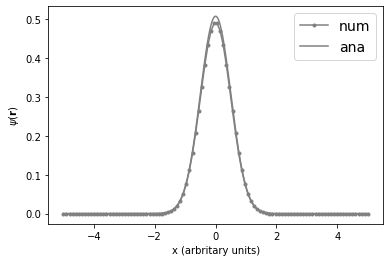

In [47]:
### For constant dielectric
const = True
N = 100
sigma_filter = 0.0

res_1 = run_GPE_solver(N,sigma_filter,const)

elec_potential, accuray, delta_arr,phi_pol,i = res_1
    
if const == True:
    N_halfway = round(N/2)-1
    x = np.linspace(-5,5,N, dtype = "f4") #f8
    x_ana = np.linspace(-5,5,1000); y_ana = z_ana = 0.0
    psi_cont = psi_analytic(x_ana,y_ana,z_ana,mu_x,mu_y,mu_z)
    
    ### plotting 
    plt.plot(x,elec_potential[:, N_halfway, N_halfway] , ".-", color = "grey", label = "num")
    plt.plot(x_ana, psi_cont, label = "ana", color = "grey")
    plt.xlabel("x (arbritary units)")
    plt.ylabel(r"$\psi(\mathbf{r})$")
    plt.legend(fontsize = 14)
    plt.show() 

The iterative method stops after just 1 iteration, when the input charge densities $\rho(\mathbf{r})$ comes from a GPE with a constant dieletric of $80$. The numerical method matches the analytical $\psi(\mathbf{r})$.

## Variable $\epsilon(r)$
Here, I am interested in investigating some aspects of the iterative method:
* How does different $\sigma$ in the window function (smearing of charge number densities) affect the convergence, stability of convergence and accuracy of the numerical GPE-solver?
* How does the convergence depend upon different grid resolutions?

### Convergence and accuracy with variable smearing ($\sigma$)

First, lets investigate convergence and different levels of smearing. To do so, I run the iterative GPE solver with $\rho(\mathbf{r})$ and $\epsilon(\mathbf{r})$ as input, with different levels of smearing.

In [48]:
# sigma 0
N = 100
sigma_filter = 0.0

res_2 = run_GPE_solver(N,sigma_filter)
elec_potential, accuracy, delta_arr, phi_pol, i = res_2

elec_potential_sigma0 = elec_potential
delta_arr_sigma0 = delta_arr
accuracy_sigma0 = accuracy

Stopping after iteration 8 with stop crit 1.00e-06, delta 6.90e-07


In [49]:
# sigma 0.1
N = 100
sigma_filter = 0.1

res_3 = run_GPE_solver(N,sigma_filter)
elec_potential, accuracy, delta_arr, phi_pol, i = res_3
elec_potential_sigma01 = elec_potential
delta_arr_sigma01 = delta_arr
accuracy_sigma01 = accuracy

Stopping after iteration 8 with stop crit 1.00e-06, delta 7.75e-07


In [50]:
# sigma 0.2
N = 100
sigma_filter = 0.2

res_4 = run_GPE_solver(N,sigma_filter)
elec_potential, accuracy, delta_arr, phi_pol, i = res_4

elec_potential_sigma02 = elec_potential
delta_arr_sigma02 = delta_arr
accuracy_sigma02 = accuracy

Stopping after iteration 8 with stop crit 1.00e-06, delta 9.32e-07


In [51]:
# sigma 0.3
N = 100
sigma_filter = 0.3

res_5 = run_GPE_solver(N,sigma_filter)
elec_potential, accuracy, delta_arr,phi_pol, i = res_5

elec_potential_sigma03 = elec_potential
delta_arr_sigma03 = delta_arr
accuracy_sigma03 = accuracy

Stopping after iteration 8 with stop crit 1.00e-06, delta 1.00e-06


In [52]:
# sigma 0.4
N = 100
sigma_filter = 0.4

res_6 = run_GPE_solver(N,sigma_filter)
elec_potential, accuracy, delta_arr, phi_pol, i = res_6

elec_potential_sigma04 = elec_potential
delta_arr_sigma04 = delta_arr
accuracy_sigma04 = accuracy

Stopping after iteration 8 with stop crit 1.00e-06, delta 9.50e-07


In [53]:
# sigma 0.5
N = 100
sigma_filter = 0.5

res_7 = run_GPE_solver(N,sigma_filter)
elec_potential, accuracy, delta_arr,phi_pol, i = res_7

elec_potential_sigma05 = elec_potential
delta_arr_sigma05 = delta_arr
accuracy_sigma05 = accuracy

Stopping after iteration 8 with stop crit 1.00e-06, delta 8.31e-07


In [47]:
# sigma 0.9
N = 30
sigma_filter = 0.9

res_8 = run_GPE_solver(N,sigma_filter)
elec_potential, accuracy, delta_arr,phi_pol, i = res_8

elec_potential_sigma09 = elec_potential
delta_arr_sigma09 = delta_arr
accuracy_sigma09 = accuracy

Stopping after iteration 119 with stop crit 1.00e-06, delta 9.73e-07


In [48]:
# sigma 1.2
N = 30
sigma_filter = 1.2

res_8 = run_GPE_solver(N,sigma_filter)
elec_potential, accuracy, delta_arr,phi_pol, i = res_8

elec_potential_sigma12 = elec_potential
delta_arr_sigma12 = delta_arr
accuracy_sigma12 = accuracy

Stopping after iteration 97 with stop crit 1.00e-06, delta 9.73e-07


After running the above cells, plots can be generated to see the dependence on $\sigma$ and wether the iterative method is able to reproduce $\psi(\mathbf{r})$.

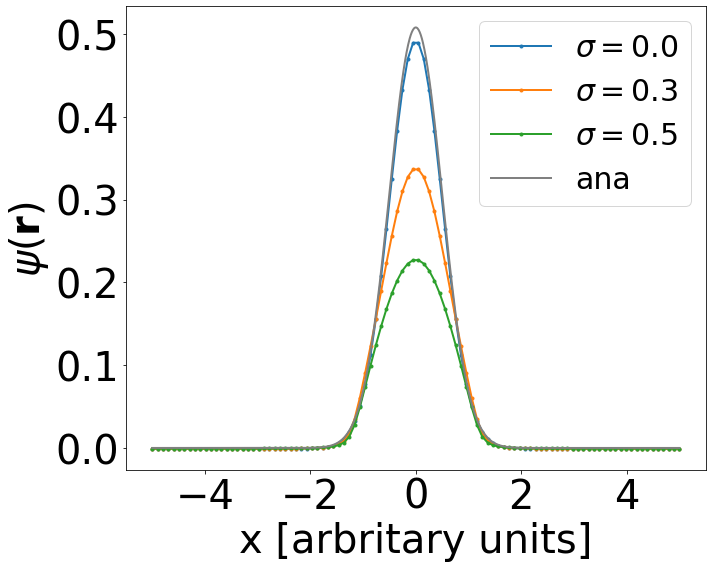

In [54]:
### For variable dielectric
smearing = True 
fs = 40
fs_leg = 30
width = 2
N = 100

plt.figure(figsize = (10,8))
x_ana = np.linspace(-5,5,1000); y_ana = z_ana = 0.0
psi_cont = psi_analytic(x_ana,y_ana,z_ana,mu_x,mu_y,mu_z)

N_halfway = round(N/2)-1

# spatial array
x = np.linspace(-5,5,N, dtype = "f4") 
x2 = np.linspace(-5,5,30, dtype = "f4") 


### plotting
if smearing == True:
    plt.plot(x,elec_potential_sigma0[:,N_halfway,N_halfway] , ".-", label = "$\sigma = 0.0$", linewidth = width)
    #plt.plot(x,elec_potential_sigma01[:,N_halfway,N_halfway] , ".-", label = "$\sigma = 0.1$", linewidth = width)
    #plt.plot(x,elec_potential_sigma02[:,N_halfway,N_halfway] , ".-", label = "$\sigma = 0.2$",linewidth = width)
    plt.plot(x,elec_potential_sigma03[:,N_halfway,N_halfway] , ".-", label = "$\sigma = 0.3$",linewidth = width)
    #plt.plot(x,elec_potential_sigma04[:,N_halfway,N_halfway] , ".-", label = "$\sigma = 0.4$",linewidth = width)
    plt.plot(x,elec_potential_sigma05[:,N_halfway,N_halfway] , ".-", label = "$\sigma = 0.5$",linewidth = width)
    #plt.plot(x2,elec_potential_sigma09[:,14,14] , ".-", label = "$\sigma = 0.9$",linewidth = width)
    #plt.plot(x2,elec_potential_sigma12[:,14,14] , ".-", label = "$\sigma = 1.2$",linewidth = width)
    #plt.plot(x,elec_potential_sigma09[:,N_halfway,N_halfway] , ".-", label = "$\sigma = 0.9$",linewidth = width)
    #plt.plot(x,elec_potential_sigma12[:,N_halfway,N_halfway] , ".-", label = "$\sigma = 1.2$",linewidth = width)


else: 
    ## optional - to see trajectory
    #for k in range(2):
    #        plt.plot(x, num_sols[k][:,N_halfway,N_halfway], ".-", color = "grey",alpha = 0.5)
     plt.plot(x,elec_potential[:,N_halfway,N_halfway] , ".-", color = "orange", label = "num", linewidth = width)

plt.plot(x_ana,psi_cont, label = "ana", color = "grey", linewidth = width) #color = "royalblue") #, alpha = 0.5)
plt.xlabel("x [arbritary units]",fontsize = fs)
plt.ylabel(r"$\psi(\mathbf{r})$",fontsize = fs)
plt.legend(fontsize = fs_leg)
plt.xticks(fontsize = fs)
plt.yticks(fontsize = fs)
plt.tight_layout()
plt.savefig("./figs/converged-numericalpotentials-v1-grey", format = "pdf")
plt.show() 

It is clear that the smearing of $\rho(\mathbf{r})$ affects the amplitude of the converged numerical solution, $\psi^n$. The higher value of $\sigma$, the lower amplitude of $\psi^n$. Otherwise, the numerical solution from the iterative GPE-solver is consistent with the analytical $\psi(\mathbf{r})$. The cell below, shows the effect of having a variable dielectric $\epsilon(\mathbf{r})$ as input. Due to shielding caused by a polarizable medium, the effective charge densities becomes lower, i.e. $\rho(\mathbf{r}) + \rho_\text{pol} < \rho(\mathbf{r})$, and $\rho_\text{pol}$ is negative.

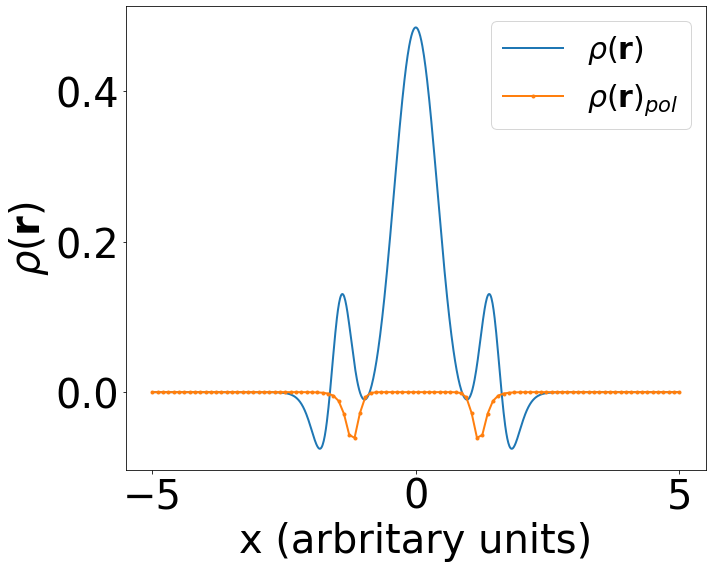

In [15]:
### polarization charges
plt.figure(figsize = (10,8))
plt.plot(x_ana,densities_analytic(x_ana,y_ana,z_ana,mu_x,mu_y,mu_z) * COULK_GMX, label = r"$\rho(\mathbf{r})$", linewidth = width)
plt.plot(x, phi_pol[:,N_halfway,N_halfway] * COULK_GMX,".-", label = r"$\rho(\mathbf{r})_{pol}$", linewidth = width)
plt.xlabel("x (arbritary units)",fontsize = fs)
plt.ylabel(r"$\rho(\mathbf{r})$",fontsize = fs)
plt.tick_params(axis='x', labelsize= fs); plt.tick_params(axis='y', labelsize= fs)
plt.legend(fontsize = fs_leg)
plt.tight_layout()
plt.savefig("./figs/pol-charges",format = "pdf")
plt.show()

Below, the dependence on $\sigma$ and iteration are shown for accuracy and convergence.

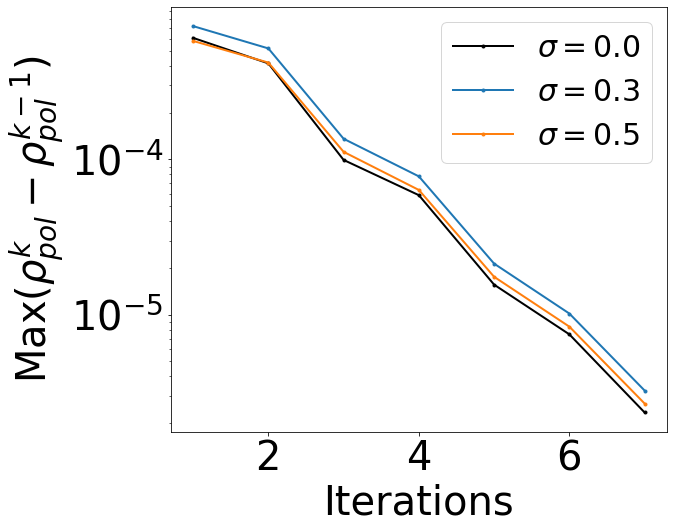

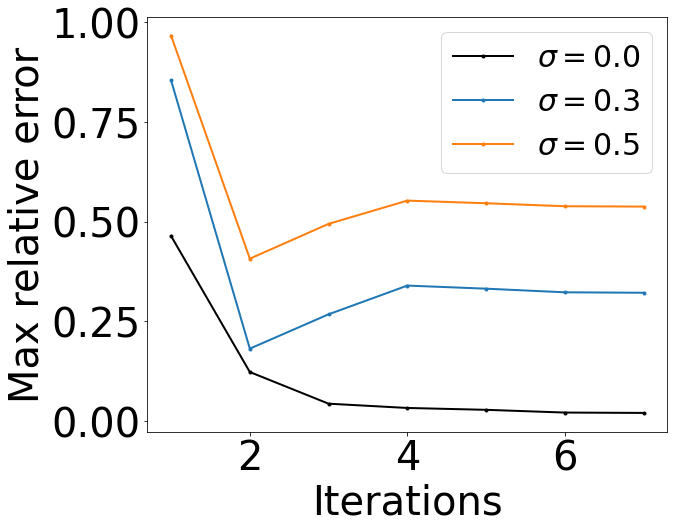

In [91]:
iterations = np.linspace(1,i,i)

### Plotting the max difference of rho^n - rho^{n-1} used as convergence criteria ### 
plt.figure(figsize = (10,8))
plt.plot(iterations,delta_arr_sigma0[0:i],".-", color = "black",linewidth = width, label = "$\sigma = 0.0$")
plt.plot(iterations,delta_arr_sigma03[0:i],".-",linewidth = width, label = "$\sigma = 0.3$")
plt.plot(iterations,delta_arr_sigma05[0:i],".-",linewidth = width, label = "$\sigma = 0.5$")
plt.xlabel("Iterations",fontsize = fs)
plt.ylabel(r"Max($\rho_{pol}^{k} - \rho_{pol}^{k-1})$",fontsize = fs)
plt.yscale("log")  
plt.tick_params(axis='x', labelsize= fs);
plt.tick_params(axis='y', labelsize= fs)
plt.legend(fontsize = fs_leg)
plt.tight_layout(pad = 3.0)
plt.savefig("./figs/convergence-maxdiff-v1", format = "pdf")
plt.show()

### Plotting the accuracy 
scaling = float(np.max(psi_cont))

plt.figure(figsize = (10,8))
plt.plot(iterations,accuracy_sigma0[0:i]/scaling,".-", color = "black",linewidth = width, label = "$\sigma = 0.0$")
plt.plot(iterations,accuracy_sigma03[0:i]/scaling,".-",linewidth = width, label = "$\sigma = 0.3$")
plt.plot(iterations,accuracy_sigma05[0:i]/scaling,".-",linewidth = width, label = "$\sigma = 0.5$")
plt.xlabel("Iterations", fontsize = fs)
plt.ylabel("Max relative error", fontsize = fs)  
plt.tick_params(axis='x', labelsize= fs); 
plt.tick_params(axis='y', labelsize= fs)
plt.legend(fontsize = fs_leg)
plt.tight_layout(pad = 3.0)
plt.savefig("./figs/convergence-accuracy-v1", format = "pdf")
plt.show()



The above plot show that the convergence in the iterative method is logaritmic (base 10) for all $\sigma$'s used in the plot. However, due to smearing, the maximum relative error increases with a non-zero $\sigma$, i.e. the accuracy becomes worse, comparing with no 

Now that the concequences of $\sigma$ has been explored, it is time to explore the effects of grid-size on the iterative GPE-solvers accuracy.

### Effects of grid resolution on accuracy
Below are the numerical results for a grid size of $N_x = N_y = N_z = \{10,15,20,25,26,27,28,29,30,35,40,45,50,60,70,80,90,100\}$ with $\sigma = \{0,0.3,0.5,0.7,0.9,1.1,1.3\}$.

In [79]:
# Obtain results
# x-axis (30,35,40,45,50,60,70,80,90,100) 
# sigma0, sigma0.3, sigma 0.5

N = [10,15,20,25,26,27,28,29,30,35,40,45,50,60,70,80,90,100]
sigma = [0,0.3,0.5,0.7,0.9,1.1,1.3]
len_ = int(len(N)*len(sigma))
n_cols = len(N)  # think of sigma's being rows
n_rows = len(sigma)

final_acc = np.zeros(len_)
final_conv = np.zeros(len_)
max_iter = np.zeros(len_)


for j in range(len(sigma)):
    for m in range(len(N)): 
        print("Result ",j*n_cols + m + 1, " of", len_)
        res_8 = run_GPE_solver(N[m],sigma[j])
        elec_potential, accuracy, delta_arr, phi_pol, i = res_8

        final_conv[j*n_cols + m] = delta_arr[i-1]
        final_acc[j*n_cols + m] = accuracy[i-1]
        max_iter[j*n_cols + m] = i

Result  1  of 126
Stopping after iteration 35 with stop crit 1.00e-06, delta nan
Result  2  of 126


/srv/conda/envs/notebook/lib/python3.9/site-packages/pmesh/pm.py:692: RuntimeWarning: invalid value encountered in multiply
  out.value[...] *= numpy.prod(self.Nmesh ** -1.0)
/tmp/ipykernel_547/980113698.py:113: RuntimeWarning: invalid value encountered in true_divide
  return potential/k.normp(p=2, zeromode = 1)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pmesh/pm.py:188: RuntimeWarning: overflow encountered in multiply
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pmesh/pm.py:188: RuntimeWarning: overflow encountered in add
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_547/980113698.py:126: RuntimeWarning: invalid value encountered in multiply
  return  additive_terms * (- 1j * k[_d]) / k.normp(p=2, zeromode=1)


Stopping after iteration 83 with stop crit 1.00e-06, delta nan
Result  3  of 126
Stopping after iteration 60 with stop crit 1.00e-06, delta nan
Result  4  of 126
Stopping after iteration 362 with stop crit 1.00e-06, delta nan
Result  5  of 126
Stopping after iteration 102 with stop crit 1.00e-06, delta nan
Result  6  of 126
Stopping after iteration 500 with stop crit 1.00e-06, delta 4.83e+36
Result  7  of 126
Stopping after iteration 296 with stop crit 1.00e-06, delta nan
Result  8  of 126
Stopping after iteration 305 with stop crit 1.00e-06, delta nan
Result  9  of 126
Stopping after iteration 164 with stop crit 1.00e-06, delta 9.74e-07
Result  10  of 126
Stopping after iteration 19 with stop crit 1.00e-06, delta 8.19e-07
Result  11  of 126
Stopping after iteration 9 with stop crit 1.00e-06, delta 7.62e-07
Result  12  of 126
Stopping after iteration 8 with stop crit 1.00e-06, delta 6.35e-07
Result  13  of 126
Stopping after iteration 8 with stop crit 1.00e-06, delta 6.40e-07
Result  1

Stopping after iteration 104 with stop crit 1.00e-06, delta 9.84e-07
Result  100  of 126
Stopping after iteration 13 with stop crit 1.00e-06, delta 9.30e-07
Result  101  of 126
Stopping after iteration 7 with stop crit 1.00e-06, delta 6.50e-07
Result  102  of 126
Stopping after iteration 7 with stop crit 1.00e-06, delta 6.28e-07
Result  103  of 126
Stopping after iteration 7 with stop crit 1.00e-06, delta 6.29e-07
Result  104  of 126
Stopping after iteration 7 with stop crit 1.00e-06, delta 6.64e-07
Result  105  of 126
Stopping after iteration 7 with stop crit 1.00e-06, delta 6.86e-07
Result  106  of 126
Stopping after iteration 7 with stop crit 1.00e-06, delta 6.89e-07
Result  107  of 126
Stopping after iteration 7 with stop crit 1.00e-06, delta 6.86e-07
Result  108  of 126
Stopping after iteration 7 with stop crit 1.00e-06, delta 6.72e-07
Result  109  of 126
Stopping after iteration 35 with stop crit 1.00e-06, delta nan
Result  110  of 126
Stopping after iteration 85 with stop crit 1

First investigate the values:

In [81]:
print("Mesh grid sizes: ", N)
print("sigmas: ", sigma)
print("\n\n")
print("Accuracy \n",final_acc)
print("\n\n")
print("Convergence ", final_conv)
print("\n\n")
print("iterations until convergence ", max_iter)

Mesh grid sizes:  [10, 15, 20, 25, 26, 27, 28, 29, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
sigmas:  [0, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3]



Accuracy 
 [       nan        nan        nan        nan        nan        nan
        nan        nan 1.8815186  0.06217502 0.01369011 0.02338314
 0.01842999 0.0168502  0.01477346 0.01313776 0.01183885 0.01078349
        nan        nan        nan        nan        nan        nan
        nan        nan 1.14091158 0.15925691 0.14623189 0.17845345
 0.15864643 0.16194806 0.16306135 0.1635547  0.16373953 0.16376221
        nan        nan        nan        nan        nan        nan
        nan        nan 0.667656   0.27018607 0.24623352 0.28740984
 0.26121193 0.26700228 0.26989758 0.27161321 0.27267474 0.27335104
        nan        nan        nan        nan        nan        nan
        nan        nan 0.2696926  0.35533178 0.32236987 0.36605197
 0.33772346 0.3445417  0.34824607 0.35052472 0.35199729 0.35298526
        nan        nan        nan        nan   

From the above prints, note that $N < 30$ leads to no valid convergence of the iterative GPE-solver method (accuracy nan). After obtain the results, the convergence and accuracy can be plotted as a function of $N$.

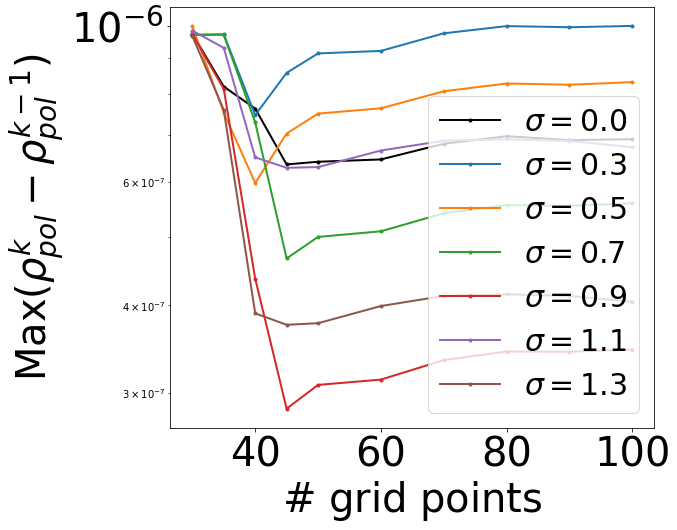

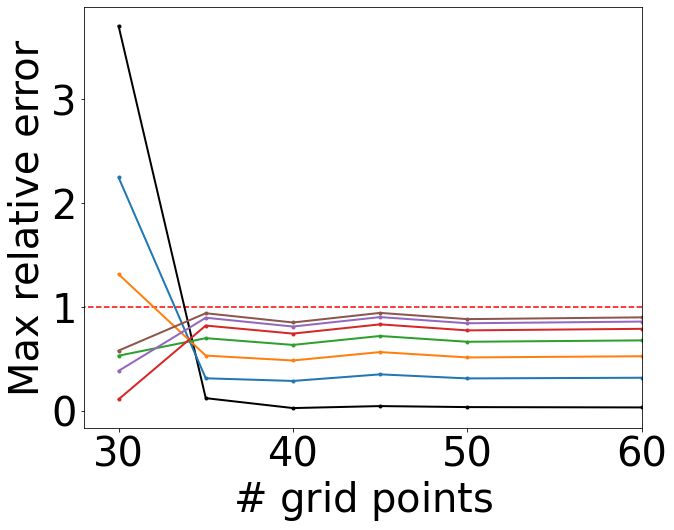

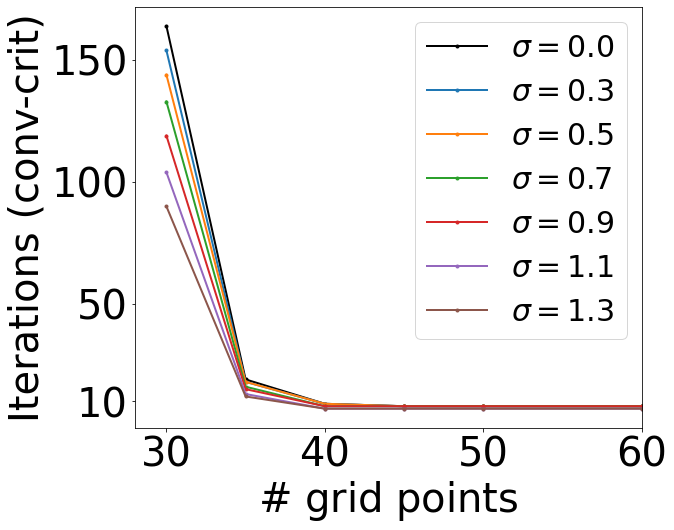

In [98]:
skip = 8
step = 10
end1 = skip + step
end2 = 2*end1
end3 = 3*end1
end4 = 4*end1
end5 = 5*end1
end6 = 6*end1
end7 = 7*end1

scaling = float(np.max(psi_cont))

### Plotting the max difference of rho^n - rho^{n-1} used as convergence criteria ### 
plt.figure(figsize = (10,8))
plt.plot(N[skip:],final_conv[skip:end1],".-", color = "black",linewidth = width, label = "$\sigma = 0.0$")
plt.plot(N[skip:],final_conv[end1 + skip:end2],".-",linewidth = width, label = "$\sigma = 0.3$")
plt.plot(N[skip:],final_conv[end2 + skip:end3],".-",linewidth = width, label = "$\sigma = 0.5$")
plt.plot(N[skip:],final_conv[end3 + skip:end4],".-",linewidth = width, label = "$\sigma = 0.7$")
plt.plot(N[skip:],final_conv[end4 + skip:end5],".-",linewidth = width, label = "$\sigma = 0.9$")
plt.plot(N[skip:],final_conv[end5 + skip:end6],".-",linewidth = width, label = "$\sigma = 1.1$")
plt.plot(N[skip:],final_conv[end6 + skip:end7],".-",linewidth = width, label = "$\sigma = 1.3$")

plt.xlabel("$\#$ grid points",fontsize = fs)
plt.ylabel(r"Max($\rho_{pol}^{k} - \rho_{pol}^{k-1})$",fontsize = fs)
plt.yscale("log")  
plt.tick_params(axis='x', labelsize= fs);
plt.tick_params(axis='y', labelsize= fs)
plt.legend(fontsize = fs_leg)
plt.tight_layout(pad = 3.0)
plt.savefig("./figs/convergence-N-dependence", format = "pdf")
plt.show()

### Plotting the accuracy 
plt.figure(figsize = (10,8))
plt.plot(N[skip:],final_acc[skip:end1]/scaling,".-", color = "black",linewidth = width, label = "$\sigma = 0.0$")
plt.plot(N[skip:],final_acc[end1 + skip:end2]/scaling,".-",linewidth = width, label = "$\sigma = 0.3$")
plt.plot(N[skip:],final_acc[end2 + skip:end3]/scaling,".-",linewidth = width, label = "$\sigma = 0.5$")
plt.plot(N[skip:],final_acc[end3 + skip:end4]/scaling,".-",linewidth = width, label = "$\sigma = 0.7$")
plt.plot(N[skip:],final_acc[end4 + skip:end5]/scaling,".-",linewidth = width, label = "$\sigma = 0.9$")
plt.plot(N[skip:],final_acc[end5 + skip:end6]/scaling,".-",linewidth = width, label = "$\sigma = 1.1$")
plt.plot(N[skip:],final_acc[end6 + skip:end7]/scaling,".-",linewidth = width, label = "$\sigma = 1.3$")

plt.xlabel("$\#$ grid points", fontsize = fs)
plt.ylabel("Max relative error", fontsize = fs)
#plt.yscale("log")  
plt.tick_params(axis='x', labelsize= fs); 
plt.tick_params(axis='y', labelsize= fs)
#plt.legend(fontsize = fs_leg)
plt.xlim([28,60])
plt.tight_layout(pad = 3.0)
plt.hlines(y = 1.0, xmin = 10, xmax = 80, color='red', linestyle = "dashed")
plt.savefig("./figs/accuracy-N-dependence", format = "pdf")
plt.show()

## maximum number of iterations 
plt.figure(figsize = (10,8))
plt.plot(N[skip:],max_iter[skip:end1],".-", color = "black",linewidth = width, label = "$\sigma = 0.0$")
plt.plot(N[skip:],max_iter[end1 + skip:end2],".-",linewidth = width, label = "$\sigma = 0.3$")
plt.plot(N[skip:],max_iter[end2 + skip:end3],".-",linewidth = width, label = "$\sigma = 0.5$")
plt.plot(N[skip:],max_iter[end3 + skip:end4],".-",linewidth = width, label = "$\sigma = 0.7$")
plt.plot(N[skip:],max_iter[end4 + skip:end5],".-",linewidth = width, label = "$\sigma = 0.9$")
plt.plot(N[skip:],max_iter[end5 + skip:end6],".-",linewidth = width, label = "$\sigma = 1.1$")
plt.plot(N[skip:],max_iter[end6 + skip:end7],".-",linewidth = width, label = "$\sigma = 1.3$")

plt.xlabel("$\#$ grid points", fontsize = fs)
plt.ylabel("Iterations (conv-crit)", fontsize = fs)
plt.tick_params(axis='x', labelsize= fs); 
plt.tick_params(axis='y', labelsize= fs)
plt.yticks([10,50,100,150])
plt.legend(fontsize = fs_leg)
plt.xlim([28,60])
plt.tight_layout(pad = 3.0)
plt.savefig("./figs/max-iter-N-dependence", format = "pdf")
plt.show()

The above graphs shows that for $N < 40$, the number of iterations before convergence decreases with increasing $\sigma$. In addition, the accuracy is better (has lower value) with smearing for $N = 30$.

# Validating electric field 
Here follows code to check if the electric field is according the electric field resulting from analytical case. This did not make it to the final thesis, and should be considered additional material.

In [54]:
### Obtain analytical electric field 

### Analytical 
def E_field_ana(x,y,z,psi,mu_x,mu_y,mu_z,N):
    sigma = 0.5; #dims = 3
    field = [np.zeros((N,N,N)) for i in range (dims)]
    #print(np.shape(field))
    r_vec = [x,y,z]
    #print(np.shape(r))
    for i in range(3):
        field[i] = 1.0/(sigma**2)*psi(x,y,z,mu_x,mu_y,mu_z)*r_vec[i]
    #print(np.shape(r))    
    return field

def E_field_dot_ana(x,y,z,mu_x,mu_y,mu_z,psi):
    sigma = 0.5
    r_2 = x**2 + y**2 + z**2
    return (1.0/sigma**4)*r_2*(psi(x,y,z,mu_x,mu_y,mu_z)**2)
    

def grad_dot_E_ana(x,y,z,mu_x,mu_y,mu_z, psi):
    sigma = 0.5;
    r_2 = x**2 + y**2 + z**2
    r_vec = np.array([x,y,z], dtype = object) # PS for mesh, might need to comment out dtype
    grad_E_term = [pm.create("real", value=0.0) for i in range (dims)]
    
    for i in range(3):
        grad_E_term[i] = (2./sigma**4)*(1.0-r_2/sigma**2)*(psi(x,y,z,mu_x,mu_y,mu_z)**2)*r_vec[i]
    return grad_E_term 
        
def nabla_eps_ana(x,y,z):
    eps_0 = 78.36; delta = 0.3; d0 = 1.7
    r = np.sqrt(x**2 + y**2 + z**2)
    r_vec = np.array([x,y,z],dtype = object)
     
    grad_eps_terms = [pm.create("real", value=0.0) for i in range (dims)]
    for i in range(3):
        grad_eps_terms[i] = 1.0/(np.sqrt(np.pi)*delta*r)*(eps_0-1.0)*r_vec[i]*np.exp(-((r-d0)/delta)**2)
    return  grad_eps_terms
    

## testing 
plot_spec = True
if plot_spec == True:
    along_dim = "x"
    #along_dim = "y"
    #along_dim = "z"
    if along_dim == "x":
        d = 0
        x_ana = np.linspace(-5,5,1000); y_ana = z_ana = 0.0
    if along_dim == "y":
        d = 1
        y_ana = np.linspace(-5,5,1000); x_ana = z_ana = 0.0 
    if along_dim == "z":
        d = 2
        z_ana = np.linspace(-5,5,1000); x_ana = y_ana = 0.0 

    e_r = dielectric(x_ana,y_ana,z_ana)   
    gradEE = grad_dot_E_ana(x_ana,y_ana,z_ana,mu_x,mu_y,mu_z,psi_analytic)
    nabla_eps_a = nabla_eps_ana(x_ana,y_ana,z_ana)
    EE = E_field_dot_ana(x_ana,y_ana,z_ana,mu_x,mu_y,mu_z,psi_analytic)

else:
    E_field_ana(X,Y,Z,psi_analytic, mu_x, mu_y, mu_z)
    gradEE = grad_dot_E_ana(X,Y,Z,mu_x,mu_y,mu_z,psi_analytic)
    nabla_eps_a = nabla_eps_ana(X,Y,Z)
    EE = E_field_dot_ana(X,Y,Z,mu_x,mu_y,mu_z,psi_analytic)
    pol_forces_ana = [pm.create("real",value = 0.0) for _ in range(_SPACE_DIM)]
    eps0_inv = COULK_GMX*4*np.pi

    eps_k = 80 # for a type of imagined bead here.

    for _d in np.arange(_SPACE_DIM):
        # analytical terms
        pol_forces_ana[_d] = (1./eps0_inv) * (-0.5 * nabla_eps_a[_d]* EE \
                                           + 0.5 * (eps_k - e_r)* gradEE[_d])


In [36]:
### Numerical electric field

elec_field_fourier = [
            pm.create("complex", value=0.0) for _ in range(dims)
        ]  # for force calculation

elec_field = [
        pm.create("real", value=0.0) for _ in range(dims)
    ]  # for force calculation

(phi_q_eps + phi_pol).r2c(out = phi_q_effective_fourier)

for _d in np.arange(dims):
        def poisson_transfer_function(k, v, d=_d): # fourier solution
            return - 1j * k[_d] * 4.0 * np.pi * COULK_GMX * v / k.normp(p=2,zeromode=1)
            ######return - 1j * k[_d] * 4.0 * np.pi * v /k.normp(p=2) #hymd.py:173: RuntimeWarning: invalid value encountered in true_divide
        phi_q_effective_fourier.apply(poisson_transfer_function, out = elec_field_fourier[_d])
        elec_field_fourier[_d].c2r(out=elec_field[_d])

### Numerical force terms 
elec_field_contrib_fourier = pm.create("complex", value=0.0)
elec_field_contrib_fgrad = [pm.create("complex",value = 0.0) for _ in range(_SPACE_DIM)]
phi_eps_fgrad = [pm.create("complex",value = 0.0) for _ in range(_SPACE_DIM)]
phi_eps_grad =  [pm.create("real",value = 0.0) for _ in range(_SPACE_DIM)]
elec_field_contrib_grad = [pm.create("real",value = 0.0) for _ in range(_SPACE_DIM)]
pol_forces =  [pm.create("real",value = 0.0) for _ in range(_SPACE_DIM)]
#pol_forces_ana

elec_field_contrib = (elec_field[0]*elec_field[0] + \
             elec_field[1]*elec_field[1] +  elec_field[2]*elec_field[2])#/denom_phi_tot;
#print("max E field val {:.2f} rank {:d}".format(np.max(elec_field),comm.Get_rank()))
elec_field_contrib.r2c(out = elec_field_contrib_fourier)

for _d in np.arange(_SPACE_DIM):
    def gradient_transfer_function(k,x, d = _d):
        return  1j * k[_d] * x        ## derivative
    elec_field_contrib_fourier.apply(gradient_transfer_function,out = elec_field_contrib_fgrad[_d])
    phi_eps_fourier.apply(gradient_transfer_function,out = phi_eps_fgrad[_d])
    elec_field_contrib_fgrad[_d].c2r(out = elec_field_contrib_grad[_d])
    phi_eps_fgrad[_d].c2r(phi_eps_grad[_d])


eps0_inv = COULK_GMX*4*np.pi

eps_k = 80 # for a type of imagined bead here.

for _d in np.arange(_SPACE_DIM):
    # numerical terms
    pol_forces[_d] =  (1./eps0_inv)*(- 0.5 *(phi_eps_grad[_d] \
                        * elec_field_contrib) \
                        + 0.5 * (eps_k - phi_eps) \
                        * (elec_field_contrib_grad[_d]))
    # analytical terms
#    pol_forces_ana_mesh[_d] = (1./eps0_inv) * (-0.5 * nabla_eps_a[_d]* EE \
#                                       + 0.5 * (eps_k - e_r)* gradEE[_d])



Plot numerical electric field against analytical...

In [55]:
## alternative way of obtaining E field through potential

elec_field2 = [
        pm.create("real", value=0.0) for _ in range(dims)
    ]  
for _d in np.arange(dims):
    def field_transfer_function(k,x, d =_d):
        return  -1j*k[_d]*x         ## negative sign relation here due to E = - nabla psi relation

    elec_potential_fourier.apply(field_transfer_function, out = phi_eta_fourier[_d])
    phi_eta_fourier[_d].c2r(out=elec_field2[_d])
## ^-------- Method: Obtaining the electric field from potential

8.131202e-07
-3.5729528e-07
1.0944292e-06


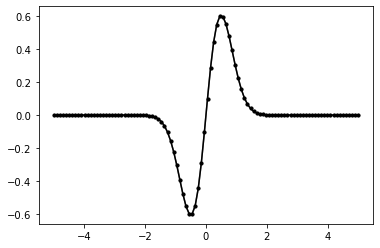

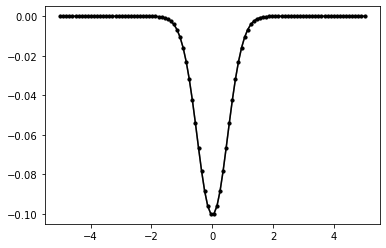

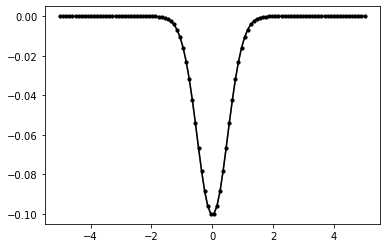

In [39]:
# Checking differences between analytical and numerical
#sum_dims = 0
#sum_dims_ana = 0
#for _d in range(_SPACE_DIM):
#    sums = np.sum(pol_forces[_d]-pol_forces_ana[_d])
#    #sum_dims += 
#    #sum_dims_ana += 
#    #print(np.max(pol_forces[_d]-pol_forces_ana[_d]))
#    print(sums)
    

#np.max(pol_forces_ana)
# check that E-field is the same
#sum_dims = 0
for i in range(dims):
    sum_elec = np.sum(elec_field[i] - elec_field2[i])
    print(sum_elec)

N_halfway = 50-1

plt.plot(x,elec_field[0][:,N_halfway,N_halfway] , ".-", color = "grey", label = "num2")
plt.plot(x,elec_field2[0][:,N_halfway,N_halfway] , ".-", color = "black", label = "num2")
plt.show()

plt.plot(x,elec_field[1][:,N_halfway,N_halfway] , ".-", color = "grey", label = "num2")
plt.plot(x,elec_field2[1][:,N_halfway,N_halfway] , ".-", color = "black", label = "num2")
plt.show()

plt.plot(x,elec_field[2][:,N_halfway,N_halfway] , ".-", color = "grey", label = "num2")
plt.plot(x,elec_field2[2][:,N_halfway,N_halfway] , ".-", color = "black", label = "num2")
plt.show()